## Data Processing
---

* Todo
    * produce unimputed data
    * produce imputed data
    * update config

In [1]:
import sys, os, json, copy, sklearn, shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle as pkl
from tqdm import tqdm
from smart_open import open
import matplotlib.pyplot as plt
from rdsutils.metrics import get_pred_reports
from rdsutils.woe import WOE_Transform

sys.path.insert(1, "../..")
from src.preprocess import Preprocess
from src.imputer import WOEImputer
from src.feature_selection import (
    FeatureSelector, 
    get_monotone_dir,
    get_feature_rankings, 
    remove_features, 
    default_params,
    get_top_k_features
)

from rdsutils.feature_selection import FeatureSelector as general_purpose_fsel
from rdsutils.feature_selection import mrmr

%load_ext autoreload
%autoreload 2

### Load Components
---

In [2]:
seed = 42
segment = "prescreen_final"
artifact_path = "s3://sofi-data-science/jxu/pl-gen4/prescreen"
data_dir = "s3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen"
nr_to_consider = 200

with open(os.path.join(artifact_path, "config.json"), "r") as f:
    config = json.load(f)
    
display(config.keys()) 

gen3_params = config["model_params"]["gen3_params"]

if "scale_pos_weight" in gen3_params:
    del gen3_params["scale_pos_weight"]

bureau_fts = config["data_columns"]["bureau_features_cols"] 
cat_fts = ['t11_t3d_segid', 't11_t3d_segid_supp'] # config["data_columns"]["cat_cols"] 
prescreen_fts = bureau_fts + cat_fts
features = prescreen_fts

# training data
target = "target"
target_indeterminate = "indeterminate"
ri_weight = "weight_ri"
weight = "weight"
weight_eval = "weight_eval"

# meta cols
meta_cols = [
    target, target_indeterminate,
    ri_weight, weight_eval, 'applicant_fico_score',
    'applicant_type', 'applicant_vantage_score', 'date_start',
    'gen3_score', 'id','period','ri_source', 'segmentation',
    'segmentation_description',
]

dict_keys(['data', 'meta', 'data_columns', 'model_params', 'model_features', 'impute_vals', 'monotone', 'models'])

#### load PL Gen 3 model

In [4]:
with open(config["models"]["benchmark"]["pl_gen3"], "rb") as f:
    lgbm_gen3 = pkl.load(f)

In [5]:
len(lgbm_gen3.feature_name())

32

#### load Gen 4 model

In [6]:
with open(config["models"]["prescreen"]["lgbm_preliminary"], "rb") as f:
    lgbm_prem = pkl.load(f)

In [7]:
len(lgbm_prem.feature_name_)

32

#### select features to load

In [55]:
%%time
exp_dict = pd.read_csv(config["meta"]["exp_dict_path"])
dd_path = 's3://sofi-data-science/hpeng/pl-gen4/data_dump/data_dict/combined_dict.csv'
exp_ddict_updated = pd.read_csv(dd_path, index_col=0)

features = config["data_columns"]["features_v1"]
features = list(set(features))
print(len(features), len(meta_cols))

410 14
CPU times: user 123 ms, sys: 20.4 ms, total: 144 ms
Wall time: 619 ms


With the original data being too large, we stored them separatly by segmentations when carrying out the `seg by vantage` experiments. With the final feature sets ready, let's take a look

### Load Data

In [24]:
cols = meta_cols + features

dfs = {}
        
for s in tqdm(["s1", "s2", "s3"]):
    dfs[s] = pd.read_parquet(config["data"]["prescreen"][f"train_df_{s}"], columns=cols)
    
df = pd.concat(dfs.values(), axis=0)
df.reset_index(drop=True, inplace=True)

test_df = pd.read_parquet(config["data"]["prescreen"][f"test_df"], columns=cols)

100%|██████████| 3/3 [05:33<00:00, 111.20s/it]


In [25]:
print(df.shape, test_df.shape)

(4404764, 424) (1150725, 424)


### Produce Weights
---

In [26]:
# produce weights

weights = {"booked": 1,
           "proxy": 1,
           "others": 0.25}

pp = Preprocess(exp_dict)
df = pp.transform(df, features, weights, 
                  drop_indeterminate=None,   # drop indeterminate only when fitting on full
                  existing_weights_col="weight_eval")
test_df = pp.transform(test_df, features, weights,
                       drop_indeterminate=None,
                       existing_weights_col="weight_eval")

df[target_indeterminate].value_counts(), test_df[target_indeterminate].value_counts()

100%|██████████| 410/410 [18:31<00:00,  2.71s/it]



        added columns:
            weight: training sample_weight scaled using provided weights by ri_source
                weight_eval * weight_sample
        


100%|██████████| 410/410 [04:48<00:00,  1.42it/s]



        added columns:
            weight: training sample_weight scaled using provided weights by ri_source
                weight_eval * weight_sample
        


(False    4369879
 True       34885
 Name: indeterminate, dtype: int64,
 False    1139444
 True       11281
 Name: indeterminate, dtype: int64)

In [27]:
df[features].isna().mean().sort_values().tail(10)

p13_stj8120     0.897197
p13_stj8320     0.897197
p13_stj6200     0.897197
p13_mtf5124     0.903238
t11_tcol3564    0.903620
p13_mts8220     0.904867
t11_tcol2564    0.906152
p13_mtf6246     0.943617
p13_mtf6245     0.946434
p13_hlc5820     0.946771
dtype: float64

In [28]:
test_df[features].isna().mean().sort_values().tail(10)

p13_stj8120     0.891895
p13_stj8320     0.891895
p13_stj6200     0.891895
p13_mtf5124     0.897783
t11_tcol3564    0.905369
t11_tcol2564    0.908252
p13_mts8220     0.911457
p13_hlc5820     0.946567
p13_mtf6246     0.951701
p13_mtf6245     0.953972
dtype: float64

In [29]:
config["data"].keys()

dict_keys(['raw', 'clean', 'transformed', 'prescreen', 'prescreen-v2', 'prescreen-final'])

In [30]:
final_data_dir = "s3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen-final"
config["data"]["prescreen-final"] = {}
dfs = {"df": df,
       "test_df": test_df
      }

In [31]:
for dfname in tqdm(dfs):
    path = os.path.join(final_data_dir, f"{dfname}.parquet")
    config["data"]["prescreen-final"][f"{dfname}"] = path
    dfs[dfname].to_parquet(path)

with open(os.path.join(artifact_path, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

100%|██████████| 2/2 [02:09<00:00, 64.66s/it]


### Load back the data

In [32]:
df = pd.read_parquet(config["data"]["prescreen-final"]["df"])
test_df = pd.read_parquet(config["data"]["prescreen-final"]["test_df"])

In [33]:
features = config["data_columns"]["features_v1"]

In [34]:
%%time
# preprocess, one copy with missing data for bmk_params

range_dict = exp_dict[["field_name", "min", "max"]].set_index("field_name").to_dict()
min_dict = range_dict["min"]
max_dict = range_dict["max"]

mp_woe_imputer = WOEImputer(impute_method="midpoint")
mp_woe_imputer.fit(df[features], df[target], df[weight],
                   min_dict=min_dict, max_dict=max_dict)

# store a backup somewhere
path = os.path.join(artifact_path, segment, "mp_woe_imputer_full.pkl")
mp_woe_imputer.save_state_dict(path)

# transform
df_imputed = mp_woe_imputer.transform(df, inplace=True)
test_imputed = mp_woe_imputer.transform(test_df, inplace=True)

using imputer v2
processed  410  num attributes



100%|██████████| 410/410 [00:00<00:00, 669.59it/s]


failed to impute following features: 
[]


100%|██████████| 426/426 [00:01<00:00, 299.77it/s]

CPU times: user 30min 31s, sys: 1min 29s, total: 32min 1s
Wall time: 32min


In [65]:
with open(os.path.join(artifact_path, segment, "woe.pkl"), "wb") as f:
    pkl.dump(mp_woe_imputer.woe, f)
    
with open(os.path.join(artifact_path, segment, "woe_dict.pkl"), "wb") as f:
    pkl.dump(mp_woe_imputer.woe_dict, f)

In [58]:
with open(os.path.join(artifact_path, segment, "mp_woe_imputer_full.pkl"), "rb") as f:
    imputer_state_dict = pkl.load(f)

In [36]:
display(imputer_state_dict.keys())
woe_dict = imputer_state_dict["woe_dict"]

dict_keys(['impute_values', 'impute_method', 'woe_dict'])

#### save the imputed data

In [37]:
df_imputed[features].isna().mean().sort_values().tail(10)

t11_tbca3619    0.0
p13_upl8220     0.0
p13_iln5238     0.0
p13_bcc5423     0.0
p13_all6100     0.0
p13_rej5530     0.0
t11_tbcc4360    0.0
t11_tbca3319    0.0
p13_reh7120     0.0
p13_bca5430     0.0
dtype: float64

In [38]:
test_imputed[features].isna().mean().sort_values().tail(10)

t11_tbca3619    0.0
p13_upl8220     0.0
p13_iln5238     0.0
p13_bcc5423     0.0
p13_all6100     0.0
p13_rej5530     0.0
t11_tbcc4360    0.0
t11_tbca3319    0.0
p13_reh7120     0.0
p13_bca5430     0.0
dtype: float64

In [39]:
final_data_dir = "s3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen-final"
dfs = {"df_imputed": df_imputed,
       "test_df_imputed": test_imputed
      }

for dfname in tqdm(dfs):
    path = os.path.join(final_data_dir, f"{dfname}.parquet")
    config["data"]["prescreen-final"][f"{dfname}"] = path
    dfs[dfname].to_parquet(path)

with open(os.path.join(artifact_path, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

100%|██████████| 2/2 [02:11<00:00, 65.86s/it]


### Fit Final Model

In [ ]:
# load back imputed data

df_imputed = pd.read_parquet(config["data"]["prescreen-final"]["df_imputed"])
test_df_imputed = pd.read_parquet(config["data"]["prescreen_final"]["test_df_imputed"])

In [57]:
features = ['p13_upl8132', 'p13_bcc8322', 'p13_bcc5520',
    't11_tall3205', 'p13_upl0438', 'p13_all7312', 
    'p13_all7518', 'p13_rta7300', 'p13_iqz9420', 
    'p13_iqf9540', 'p13_iqt9510', 'p13_iqz9425', 't11_trev0722', 
    't11_tstu2752', 't11_tiln2755', 't11_tmti2752',  
    't11_tiln2754', 'p13_all7936', 'p13_all8352', 'p13_cru1300',
    'p13_reh7120', 't11_tbca2526', 't11_tbca3530', 
    't11_tbca4504', 't11_tbca2381', 't11_tbcc3305',
    't11_tbcc1303', 'p13_upl8320', 'p13_aut8140',
    'p13_cru8320', 'p13_alj8120', 'p13_rtr5520',
]

params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.006631163485490334,
 'max_depth': 8,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 2500,
 'n_jobs': -1,
 'num_leaves': 45,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'auc',
 'verbosity': -1,
 'early_stopping_rounds': None,
 'feature_pre_filter': False,
 'lambda_l1': 3.882047094083081,
 'lambda_l2': 8.355557408730407,
 'feature_fraction': 0.8692351699685861,
 'bagging_fraction': 0.8941003105420229,
 'min_data_in_leaf': 700,
}

monotone_dict = get_monotone_dir(woe_dict)
mc = [monotone_dict[f] for f in features]
params["monotone_constraints"] = mc


path = os.path.join(artifact_path, segment, "monotone_dict.json")
with open(path, "w") as f:
    json.dump(monotone_dict, f, indent=4)

In [41]:
train_df = df_imputed[~df_imputed[target_indeterminate]]
train_df[target_indeterminate].value_counts()

False    4369879
Name: indeterminate, dtype: int64

In [42]:
n_samples = 100000
sample_df = train_df.sample(n_samples, random_state=seed)

shaps = {}
models = {}

lgbm_ = lgb.LGBMClassifier(**params)
lgbm_.fit(train_df[features],
          train_df[target], 
          train_df[weight],
          verbose=100
          )

models[f"lgbm_{len(features)}_hp"] = lgbm_

# shap
explainer = shap.TreeExplainer(lgbm_)
shap_values = explainer.shap_values(sample_df[lgbm_.feature_name_].values)

def get_feature_shap_abs(shap_values, columns, weight_series=None):
    if weight_series is None:
        agg_fn = lambda x: np.abs(x).mean()
    else:
        agg_fn = lambda x: (np.abs(x) * weight_series.values).mean()
    result = pd.DataFrame(shap_values, columns=columns)\
                    .apply(agg_fn, axis=0)\
                    .sort_values(ascending=False)
    return result


shap_vals = get_feature_shap_abs(shap_values[1], lgbm_.feature_name_, sample_df[weight])
shaps[f"lgbm_{len(features)}_hp"] = shap_vals

[LightGBM] [Warning] feature_fraction is set=0.8692351699685861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8692351699685861
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=8.355557408730407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.355557408730407
[LightGBM] [Warning] bagging_fraction is set=0.8941003105420229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8941003105420229
[LightGBM] [Warning] lambda_l1 is set=3.882047094083081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.882047094083081


In [43]:
features = lgbm_.feature_name_
path = f"s3://sofi-data-science/jxu/pl-gen4/models/prescreen/lgbm_{len(features)}_hp.pkl"
config["models"]["prescreen"][f"lgbm_{len(features)}_hp"] = path

with open(path, "wb") as f:
    pkl.dump(lgbm_, f)
    
with open(os.path.join(artifact_path, "config.json"), "w") as f:
    json.dump(config, f,  indent=4)

In [44]:
models["lgbm_32_hp_prelim"] = lgbm_prem

In [45]:
test_df["pred_gen3"] = -test_df["gen3_score"]

pred_cols = ["pred_gen3"]
for mname in models:
    model_ = models[mname]
    if not isinstance(model_, lgb.LGBMClassifier):
        continue
    test_df[f"pred_{mname}"] = model_.predict_proba(test_df[model_.feature_name_])[:,1]
    train_df[f"pred_{mname}"] = model_.predict_proba(train_df[model_.feature_name_])[:,1]
    pred_cols.append(f"pred_{mname}")
    
pred_cols = list(set(pred_cols))

In [46]:
metrics = get_pred_reports(test_df, target, pred_cols, sample_weight_col="weight_eval")
metrics["% inc in ks"] = metrics["ks"] / metrics.loc["pred_gen3", "ks"]
metrics.sort_values("ks", inplace=True)
metrics

,auc,ap,ks,% inc in ks
pred_gen3,0.7546,0.3487,37.59,1.000000
pred_lgbm_32_hp_prelim,0.7661,0.3657,39.29,1.045225
pred_lgbm_32_hp,0.7667,0.3653,39.39,1.047885


In [47]:
print(f"===================== overall =====================")
metrics = get_pred_reports(test_df, target, pred_cols, sample_weight_col="weight_eval")
metrics["% inc in ks"] = metrics["ks"] / metrics.loc["pred_gen3", "ks"]
metrics.sort_values("auc", inplace=True)
display(metrics)

for ris in ["booked", "proxy", "others"]:
    print(f"===================== {ris} =====================")
    df_ = test_df[test_df.ri_source == ris]
    metrics = get_pred_reports(df_, target, pred_cols, sample_weight_col="weight_eval")
    metrics["% inc in ks"] = metrics["ks"] / metrics.loc["pred_gen3", "ks"]
    metrics.sort_values("auc", inplace=True)
    metrics
    display(metrics)

===================== overall =====================


,auc,ap,ks,% inc in ks
pred_gen3,0.7546,0.3487,37.59,1.000000
pred_lgbm_32_hp_prelim,0.7661,0.3657,39.29,1.045225
pred_lgbm_32_hp,0.7667,0.3653,39.39,1.047885


===================== booked =====================


,auc,ap,ks,% inc in ks
pred_gen3,0.7023,0.1148,29.88,1.000000
pred_lgbm_32_hp_prelim,0.7265,0.1237,33.29,1.114123
pred_lgbm_32_hp,0.7298,0.1273,33.41,1.118139


===================== proxy =====================


,auc,ap,ks,% inc in ks
pred_gen3,0.6950,0.1928,28.37,1.000000
pred_lgbm_32_hp_prelim,0.7095,0.2054,30.13,1.062037
pred_lgbm_32_hp,0.7117,0.2073,30.55,1.076842


===================== others =====================


,auc,ap,ks,% inc in ks
pred_gen3,0.7446,0.3714,36.10,1.000000
pred_lgbm_32_hp_prelim,0.7563,0.3887,37.97,1.051801
pred_lgbm_32_hp,0.7569,0.3886,38.05,1.054017


In [48]:
# test_df.period.value_counts()

print(f"===================== overall =====================")
metrics = get_pred_reports(test_df, target, pred_cols, sample_weight_col="weight_eval")
metrics["% inc in ks"] = metrics["ks"] / metrics.loc["pred_gen3", "ks"]
metrics.sort_values("auc", inplace=True)
display(metrics)

for p in ["oot18q1", "oot19q2"]:
    print(f"===================== full {p} =====================")
    df_ = test_df[test_df.period == p]
    metrics = get_pred_reports(df_, target, pred_cols, sample_weight_col="weight_eval")
    metrics["% inc in ks"] = metrics["ks"] / metrics.loc["pred_gen3", "ks"]
    metrics.sort_values("auc", inplace=True)
    metrics
    display(metrics)
    
for p in ["oot18q1", "oot19q2"]:
    print(f"===================== booked {p} =====================")
    df_ = test_df[(test_df.ri_source == "booked") & (test_df.period == p)]
    metrics = get_pred_reports(df_, target, pred_cols, sample_weight_col="weight_eval")
    metrics["% inc in ks"] = metrics["ks"] / metrics.loc["pred_gen3", "ks"]
    metrics.sort_values("auc", inplace=True)
    metrics
    display(metrics)

===================== overall =====================


,auc,ap,ks,% inc in ks
pred_gen3,0.7546,0.3487,37.59,1.000000
pred_lgbm_32_hp_prelim,0.7661,0.3657,39.29,1.045225
pred_lgbm_32_hp,0.7667,0.3653,39.39,1.047885


===================== full oot18q1 =====================


,auc,ap,ks,% inc in ks
pred_gen3,0.7430,0.3368,35.91,1.000000
pred_lgbm_32_hp_prelim,0.7550,0.3529,37.65,1.048454
pred_lgbm_32_hp,0.7564,0.3549,37.79,1.052353


===================== full oot19q2 =====================


,auc,ap,ks,% inc in ks
pred_gen3,0.7668,0.3622,39.44,1.000000
pred_lgbm_32_hp,0.7775,0.3779,41.14,1.043103
pred_lgbm_32_hp_prelim,0.7775,0.3810,41.03,1.040314


===================== booked oot18q1 =====================


,auc,ap,ks,% inc in ks
pred_gen3,0.7051,0.1257,30.55,1.000000
pred_lgbm_32_hp_prelim,0.7250,0.1337,33.02,1.080851
pred_lgbm_32_hp,0.7281,0.1375,32.98,1.079542


===================== booked oot19q2 =====================


,auc,ap,ks,% inc in ks
pred_gen3,0.6909,0.0966,28.44,1.000000
pred_lgbm_32_hp_prelim,0.7225,0.1068,33.38,1.173699
pred_lgbm_32_hp,0.7263,0.1105,33.15,1.165612


In [49]:
from src.utils.governance import get_feature_by_importance

def get_feature_descriptions(features, data_dict):
    dd_cols = ["field_name", "description", "long description",
               "attr_grp", "categorical", "type", 
               "tag", "min", "max"]
    dd = data_dict[dd_cols]
    dd = dd[dd.field_name.isin(features)]
            
    dd_fields = set(data_dict.field_name.unique())
    dd.set_index("field_name", inplace=True)

    bureau_fts = [f for f in features if f in dd_fields]
    bureau_dd = dd.loc[bureau_fts]
    bureau_dd["src"] = "bureau"
    bureau_dd["prefix"] = [ft.split("_")[1][:-4] for ft in bureau_dd.index]
    
    if len(features) == len(bureau_fts):
        return bureau_dd
    
    custom_ft = [f for f in features if f not in dd_fields]
    custom_dd = pd.DataFrame(index=custom_ft)
    custom_dd["src"] = "custom"
    custom_dd["prefix"] = "custom"
    return pd.concat([bureau_dd, custom_dd]).loc[features]

def to_fico_distr(tag_distr):
    distr = {}
    distr["Payment History"] = tag_distr.loc[["Payment History", "Trade Past Performance"], "counts"].sum()
    distr["Amount Owned"] = tag_distr.loc[["Balance or Credit Amount", "Utilization"], "counts"].sum()
    distr["Age/Recency"] = tag_distr.loc["Age/Recency", "counts"]
    distr["Credit Mix"] = tag_distr.loc["Credit Mix", "counts"]
    distr["New Credit"] = tag_distr.loc["Inquiry", "counts"]

    distr = pd.Series(distr).rename("counts").to_frame()
    distr["pct"] = distr["counts"] / distr["counts"].sum()
    return distr
    

In [50]:
df_unimp = pd.read_parquet(config["data"]["prescreen-final"]["df"])

In [51]:
# dd_path = 's3://sofi-data-science/hpeng/pl-gen4/data_dump/data_dict/combined_dict.csv'
# exp_ddict_updated = pd.read_csv(dd_path, index_col=0)

mname = f"lgbm_32_hp"
model = models[mname]
fts_ = model.feature_name_
shap_ = shaps[mname].rename("shap").to_frame()

#############################################
#               feature dict
#############################################
# get ranking 
sel_ft_dict = get_feature_descriptions(fts_, exp_ddict_updated)

ft_by_fimp = get_feature_by_importance(model)
sel_ft_dict = sel_ft_dict.loc[ft_by_fimp]
sel_ft_dict["rank_fimp"] = range(len(sel_ft_dict))

ft_by_shap = shap_.sort_values("shap", ascending=False).index.to_list()
sel_ft_dict = sel_ft_dict.loc[ft_by_shap]
sel_ft_dict["rank_shap"] = range(len(sel_ft_dict))

# dir
sel_ft_dict["dir"] = sel_ft_dict.index.to_series().replace(monotone_dict)

imp_mapper = dict(zip(fts_, [np.nan]*len(fts_)))
imp_mapper.update(imputer_state_dict["impute_values"])
sel_ft_dict["missing_imp_value"] = sel_ft_dict.index.to_series().replace(imp_mapper)

# get observed data min max statistic
ft_min_max = df_unimp[fts_].agg(["min", "max"]).T
ft_min_max.columns = ["observed_min", "observed_max"]
sel_ft_dict = pd.merge(sel_ft_dict, ft_min_max,
                       left_index=True, right_index=True, how="left")

# missing rate
missing_rate = df_unimp.drop_duplicates(subset="id")[fts_].isna().mean()
sel_ft_dict = pd.merge(sel_ft_dict, missing_rate.rename("pct_special_values"), 
                       left_index=True, right_index=True, how="left")

#############################################
#               distribution
#############################################
# get distributions
tag_distr = sel_ft_dict.tag.value_counts().rename("counts").to_frame()
tag_distr["pct"] = tag_distr["counts"] / tag_distr["counts"].sum()

fico_distr = to_fico_distr(tag_distr)

In [52]:
def plot_lgbm_splits(df, lgbm, features, ncols=6, figsize=None, 
                     impute_missing_dict=None, fig=None, axs=None,
                     **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    import math
    nrows = math.ceil(len(features) / ncols)
    
    if isinstance(lgbm, lgb.LGBMModel):
        lgbm = lgbm.booster_ 
        
    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    if fig is None and axs is None:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for feature, ax in zip(features, axs.flatten()):
        ax = lgb.plot_split_value_histogram(lgbm, 
                        feature, label="tree splits",
                        ax=ax, title=feature)
        
        obs_min = df[feature].min()
        obs_max = df[feature].max()
        ax.axvline(x=obs_min, color="grey", linestyle="--", label=f"observed min : {obs_min:.2f}")
        ax.axvline(x=obs_max, color="grey", linestyle="--", label=f"observed max : {obs_max:.2f}")
        
        if impute_missing_dict:
            imp_val = impute_missing_dict[feature]
            ax.axvline(x=imp_val, color="grey", linestyle=":", label=f"imputed value: {imp_val:.2f}")
        
        split_vals = lgbm.get_split_value_histogram(feature)[1]
        split_min, split_max = split_vals.min(), split_vals.max()
        
        ax.plot([],[],' ',label=f"split min : {split_min:.2f}")
        ax.plot([],[],' ',label=f"split max : {split_max:.2f}")
        
        ax.legend()
        
    fig.supxlabel("Split Histogram for LGBM", fontsize=26)
    # fig.supylabel("")
    return fig, axs

CPU times: user 1min 50s, sys: 3.12 s, total: 1min 53s
Wall time: 1min 46s


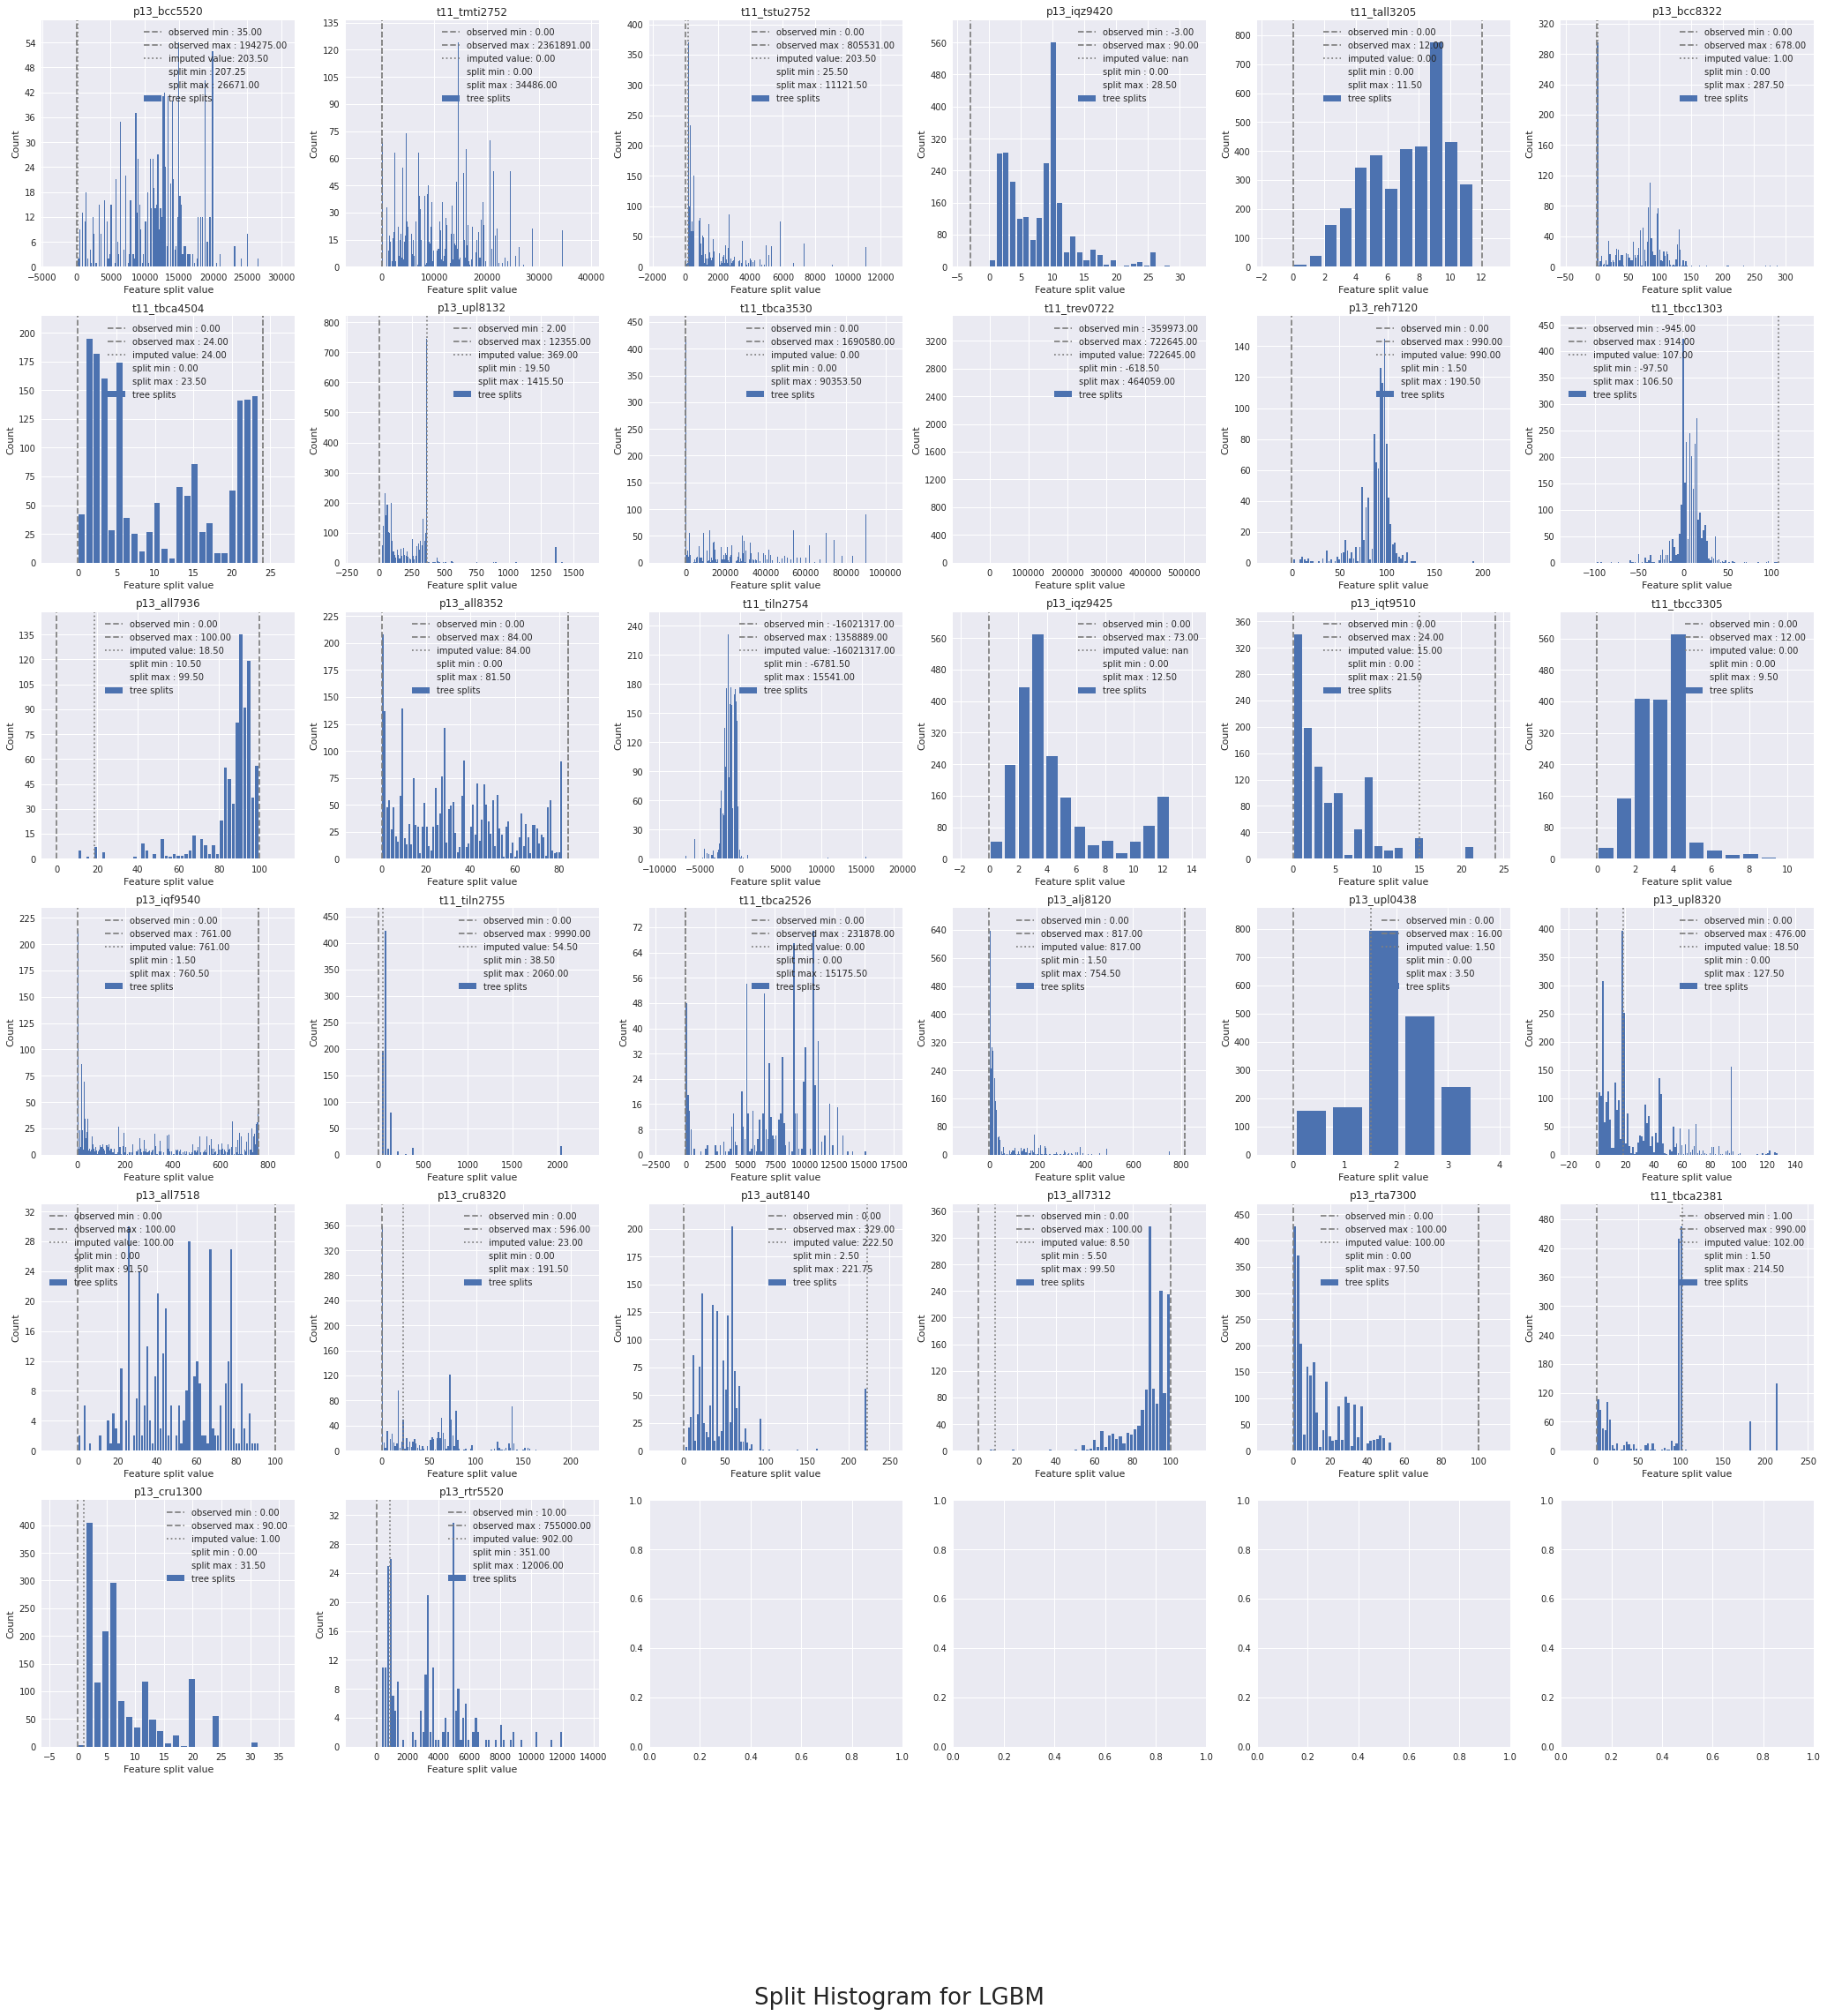

In [53]:
%%time

shap_ = shap_vals.rename("shap").to_frame()
ft_by_shap = shap_.sort_values("shap", ascending=False).index.to_list()
fig, axs = plot_lgbm_splits(df_unimp, lgbm_, ft_by_shap, impute_missing_dict=imp_mapper)